### Data Augmentation

In this notebook data augmentation is performed for improving the performances of the ConvLSTM model. 

In [1]:
%cd ..
%cd ..
# move to the root directory of the git

c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2\models
c:\Users\anton\OneDrive\Desktop\TU Delft\Q6\Data Science and Artificial Intelligence for Engineers\FLOOD_group2


In [2]:
import importlib
import torch
import joblib
import copy
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn as nn

# Enable interactive widgets in Jupyter Notebook
%matplotlib widget

from torchsummary import summary
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import make_axes_locatable

from models.ConvLSTM_model.ConvLSTM_pytorch.convlstm import ConvLSTM
from models.ConvLSTM_model.ConvLSTM_pytorch.multistep_convlstm import MultiStepConvLSTM
from models.ConvLSTM_model.train_eval import train_epoch_conv_lstm, evaluation_conv_lstm
from pre_processing.encode_decode_csv import decode_from_csv
from pre_processing.normalization import * 
from pre_processing.augmentation import *
from post_processing.cool_animation import plot_animation
from post_processing.plots import *

In [3]:
# model save path
save_path = 'models/ConvLSTM_model/model_paths/multiconv_lstm_10hid_4lay_5ker_augmentation.pth'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [5]:
train_val = 'train_val'
test1 = 'test1'
test2 = 'test2'
test3 = 'test3'

In [6]:
# training and validation dataset
train_dataset = decode_from_csv(train_val)

Restored inputs Shape: torch.Size([80, 1, 4, 64, 64])
Restored targets Shape: torch.Size([80, 48, 2, 64, 64])


In [32]:
class MultiFixedRotation:
    '''
    Class that implements random rotations of the dataset at fixed angles
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        # random.seed(seed)
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

In [255]:
def augmentation(train_dataset, angles=[90,180,270], p_hflip=0.5, full=True):
    '''
    Function for implementing data augmentation of inputs (DEM, X- and Y-Slope,
    Water Depth, and Discharge).

    Input: train_dataset = torch tensor, dataset with input variables
           seed = int, number for keeping the same random choice for trasforming both inputs and outputs in the same way, 
                  default = 42 
           angles = list of angle degrees for random rotation of the dataset, 
                    default = 90°, 180°, 270°
           p_hflip = float, probability of horizontal flipping
                     default = 0.5 
           
    Output: transformed_dataset = new dataset with augmented data,
                                  if full = True returns the original and trasformed dataset concatenated together
                                  if full = False returns only the trasformed dataset 
    '''
    
    # transformation pipeline with horizontal flip
    transformation_pipeline = transforms.Compose([
        transforms.RandomHorizontalFlip(p=p_hflip)])  
        # transforms.RandomVerticalFlip(p=p_hflip)
    
    # rotation with MultiFixedRotation class
    fixed_rotation = MultiFixedRotation(angles)

    n_samples = len(train_dataset)
    
    # trasformed_dataset = fixed_rotation(transformation_pipeline(train_dataset)) 

    # initialize lists needed for looping   
    inputs = []
    outputs = []

    transformed_inputs = []
    transformed_outputs = []

    for idx in range(len(train_dataset)):
        
        inputs.append(train_dataset[idx][0])
        outputs.append(train_dataset[idx][1])
        
        # seed = random.randint(0, 100)
        # # apply augmentation (flipping + rotation)
        # transformed_inputs.append(transformation_pipeline(train_dataset[idx][0])) # fixed_rotation(..., seed)
        # transformed_outputs.append(transformation_pipeline(train_dataset[idx][1]))   

        # transformed_inputs.append(trasformed_dataset[idx][0])
        # transformed_outputs.append(trasformed_dataset[idx][1])

    # get sizes of each dimension
    inputs_sizes = [len(inputs[0]), len(inputs[0][0]), len(inputs[0][0][0]), len(inputs[0][0][0][0])]
    outputs_sizes = [len(outputs[0]), len(outputs[0][0]), len(outputs[0][0][0]), len(outputs[0][0][0][0])]
    print(f'Inputs sizes: {inputs_sizes},\n\
Outputs sizes: {outputs_sizes}\n')

    # stack lists
    inputs_tensor = torch.stack(inputs)
    outputs_tensor = torch.stack(outputs)

    # dimension of inputs channels over which concatentate 
    inputs_flat_dim = inputs_tensor.size()[2]
    # print('flat_dim', inputs_flat_dim) 

    flattened_inputs = inputs_tensor.flatten(0,1) #alternatively try .view(-1, 64, 64) 
    flattened_outputs = outputs_tensor.flatten(1,2)
    concat = torch.cat([flattened_inputs, flattened_outputs], dim=1)

    transformed_concat = fixed_rotation(transformation_pipeline(concat))
    # print(f'Transformed concat: {transformed_concat.shape}')

    # reshape the tensors to original dimensions
    transformed_inputs = transformed_concat[:, :inputs_flat_dim, :, :].view(n_samples, inputs_sizes[0], 
                                                                            inputs_sizes[1], inputs_sizes[2], inputs_sizes[3]) 
    transformed_outputs = transformed_concat[:, inputs_flat_dim:, :, :].view(n_samples, outputs_sizes[0], 
                                                                            outputs_sizes[1], outputs_sizes[2], outputs_sizes[3])

    # print(f'Transformed inputs: {transformed_inputs.shape}')
    # print(f'Transformed inputs: {transformed_outputs.shape}')
    
    # trasformed_inputs = transformed_concat[]

    # transformed_inputs = [torch.tensor(i) for i in transformed_inputs]
    # transformed_outputs = [torch.tensor(i) for i in transformed_outputs]

    # transformed_inputs = torch.stack(transformed_inputs)
    # transformed_outputs = torch.stack(transformed_outputs)

    # concatenate tensors
    all_inputs = torch.cat([inputs_tensor, transformed_inputs])
    all_outputs = torch.cat([outputs_tensor, transformed_outputs])

    transformed_dataset = torch.utils.data.TensorDataset(all_inputs, all_outputs)
    
    if full==True:
        print(f'The samples in the dataset before augmentation were {len(train_dataset)}\n\
The samples in the dataset after augmentation are {len(transformed_dataset)}')
    
    if full==False:
        transformed_dataset = torch.utils.data.TensorDataset(transformed_inputs, transformed_outputs)
        warning_msg = (
f'\nBe careful, you are not including the transformed dataset into the original one!\n\
The samples in the dataset before augmentation were {len(train_dataset)}\n\
The samples in the dataset after augmentation are {len(transformed_dataset)}\n\
You are now using only the transformed dataset.'
)
        warnings.warn(warning_msg, RuntimeWarning)
    return transformed_dataset

In [256]:
# apply augmentation
transformed_dataset = augmentation(train_dataset, p_hflip=0.5, full=True)

Inputs sizes: [1, 4, 64, 64],
Outputs sizes: [48, 2, 64, 64]

The samples in the dataset before augmentation were 80
The samples in the dataset after augmentation are 160


In [67]:
import torch

# Example tensor with shape [80, 1, 4, 64, 64]
tensor = torch.randn(80, 1, 4, 64, 64)

# Flatten the tensor
flattened_tensor = tensor.view(-1, 64, 64)

# Get back to the original shape
original_shape_tensor = flattened_tensor.view(80, 1, 4, 64, 64)

print("Original Tensor shape:", tensor.size())
print("Flattened Tensor shape:", flattened_tensor.size())
print("Restored Tensor shape:", original_shape_tensor.size())


Original Tensor shape: torch.Size([80, 1, 4, 64, 64])
Flattened Tensor shape: torch.Size([320, 64, 64])
Restored Tensor shape: torch.Size([80, 1, 4, 64, 64])


In [8]:
# Split dataset into train and validation
train_percnt = 0.8
train_size = int(train_percnt * len(transformed_dataset))
val_size = len(transformed_dataset) - train_size
train_set, val_set = random_split(transformed_dataset, [train_size, val_size])

In [9]:
# Normalize the inputs and outputs using training dataset
scaler_x, scaler_y = scaler(train_set)

normalized_train_dataset = normalize_dataset(train_set, scaler_x, scaler_y, train_val)
normalized_val_dataset = normalize_dataset(val_set, scaler_x, scaler_y, train_val)

In [ ]:
## save scalers for use in seperate notebooks on testing
joblib.dump(scaler_x, 'models/ConvLSTM_model/scalers/scaler_x_augmentation.joblib')
joblib.dump(scaler_y, 'models/ConvLSTM_model/scalers/scaler_y_augmentation.joblib')

In [10]:
# Model
model = MultiStepConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1],
                          output_dim = normalized_train_dataset[0][1].shape[1], 
                          hidden_dim = 10, kernel_size = (5, 5), num_layers = 4,
                          batch_first=True, bias=True, return_all_layers = False).to(device)

# model = ConvLSTM(input_dim = normalized_train_dataset[0][0].shape[1], output_dim = normalized_train_dataset[0][1].shape[1], hidden_dim = 32, kernel_size = (3, 3),
#                  num_layers = 48, batch_first=True, bias=True, return_all_layers = True).to(device)

# return all layers has to be true to obtain all the outputs I think
# num_layers refers to the number of cells and thus outputs
# Number of outputs = 4 gates * hidden_dim

In [11]:
model

MultiStepConvLSTM(
  (conv2): Conv2d(10, 2, kernel_size=(1, 1), stride=(1, 1))
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(14, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1-3): 3 x ConvLSTMCell(
      (conv): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
)

In [12]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters}")
model_size_MB = num_parameters * 4 / (1024 ** 2)  # Assuming float32 precision
print(f"Model size: {model_size_MB:.2f} MB")

Number of parameters: 74182
Model size: 0.28 MB


In [13]:
# Set training parameters
learning_rate = 0.005
batch_size = 4 # Only have 64 and 16 samples for training and validation, I think should be kept small, having issues where this only works if set to 1
num_epochs = 10 #1_000

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(normalized_val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs+1):
    # Model training
    train_loss = train_epoch_conv_lstm(model, train_loader, optimizer, device)

    # Model validation
    val_loss = evaluation_conv_lstm(model, val_loader, device)

    if epoch == 1:
        best_loss = val_loss
    
    if val_loss<=best_loss:
        best_model = copy.deepcopy(model)
        best_loss = val_loss
        best_epoch = epoch
        count = 0

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    count += 1
    
    if epoch%5 == 0:
        print(f"Epoch: {epoch} " +
              f"\t Training loss: {train_loss: .2e} " + 
              f"\t Validation loss: {val_loss: .2e} " +
              f"\t Best validation loss: {best_loss: .2e}")
    stop_count = 100
    if count > stop_count:
        print(f"Loss Stagnated for {stop_count} epochs, early stopping initiated")
        break

Epoch: 5 	 Training loss:  5.24e-02 	 Validation loss:  4.38e-02 	 Best validation loss:  4.38e-02
Epoch: 10 	 Training loss:  5.24e-02 	 Validation loss:  4.38e-02 	 Best validation loss:  4.38e-02


In [15]:
model = copy.deepcopy(best_model)
torch.save(model.state_dict(), save_path)

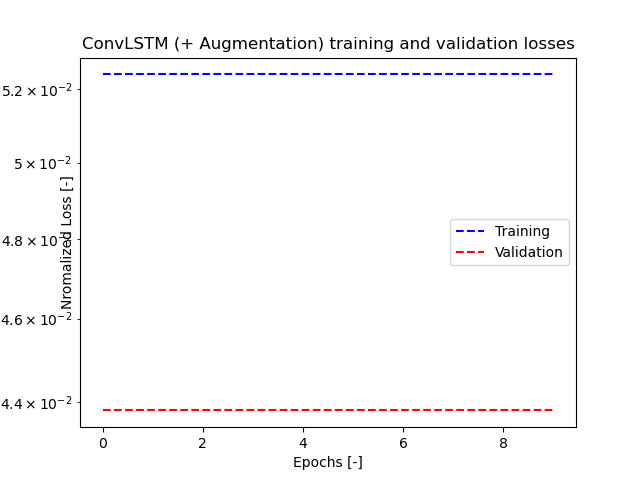

In [29]:
plot_losses(train_losses, val_losses, 'ConvLSTM (+ Augmentation) ')

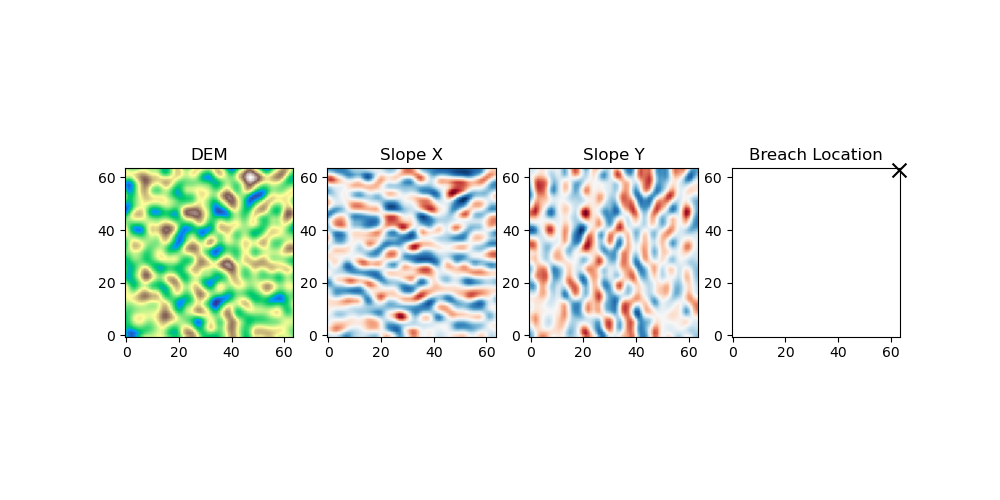

In [17]:
# From FAT application
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

# specify which entry of the dataset to plot
numb = 20
inputs = train_set[numb][0][0]

axs[0].imshow(inputs[0].cpu(), cmap='terrain', origin='lower')
axs[0].set_title('DEM')

axs[1].imshow(inputs[1].cpu(), cmap='RdBu', origin='lower')
axs[1].set_title('Slope X')

axs[2].imshow(inputs[2].cpu(), cmap='RdBu', origin='lower')
axs[2].set_title('Slope Y')

non_zero_indices = torch.nonzero(inputs[3].cpu())
non_zero_row, non_zero_col = non_zero_indices[0][0].item(), non_zero_indices[0][1].item()
axs[3].imshow(inputs[3].cpu(), cmap='binary', origin='lower')
axs[3].set_title('Breach Location')
axs[3].scatter(non_zero_col, non_zero_row, color='k', marker='x', s=100,
                clip_on = False, clip_box = plt.gca().transData)
plt.show()

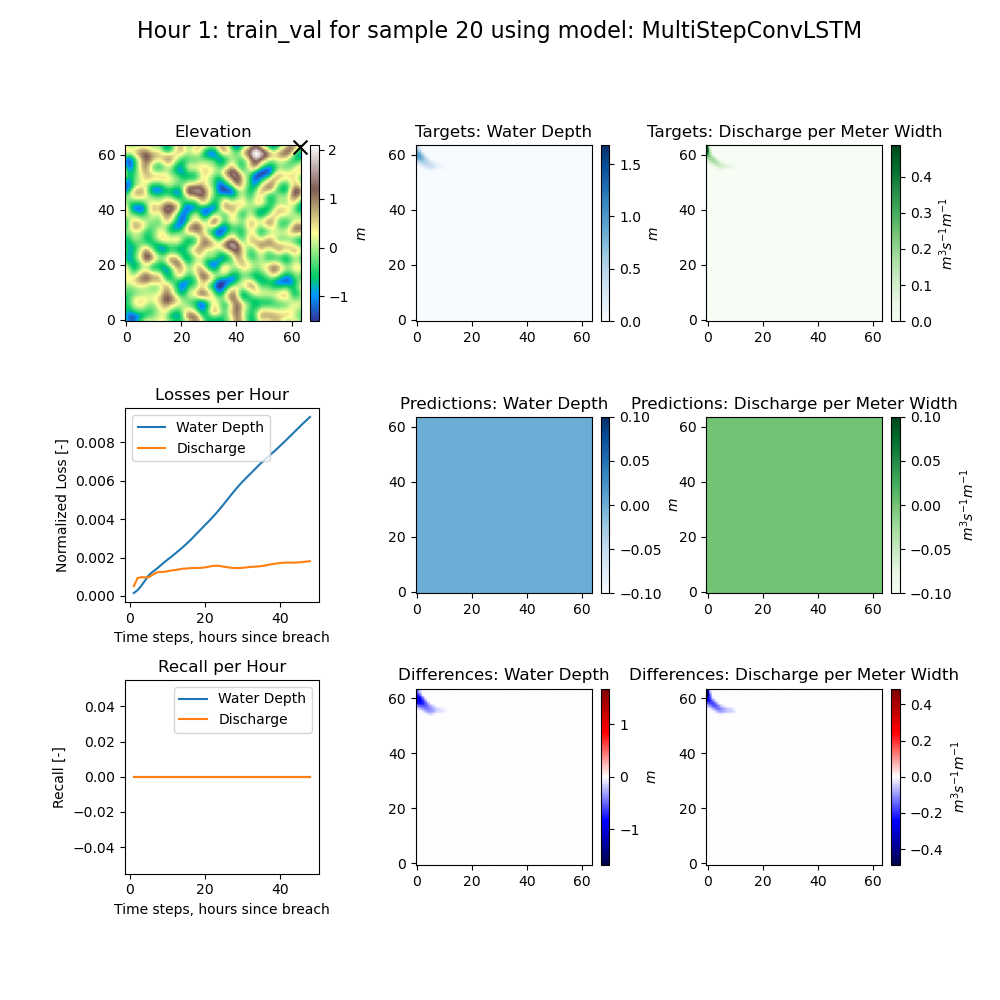

In [30]:
plot_animation(numb, normalized_train_dataset, model, train_val,
               scaler_x, scaler_y, device = device, save = False)

In [27]:
plt.imshow(normalized_train_dataset[numb][0][0][0].cpu(), cmap='terrain', origin='lower')
plt.show

<function matplotlib.pyplot.show(block=None)>

In [20]:
normalized_train_dataset[0][1].shape

torch.Size([48, 2, 64, 64])

In [31]:
# plot_sorted(normalized_train_dataset, train_val, scaler_x, scaler_y, model, device)